# 전처리 및 토큰화 과정 step by step


### Okt (전twitter)의 형태소 및 POS구분 기능 활용

전체 과정: Non-null만 추출 -> 광고성 글 제거 -> soynlp normalizer -> soyspacing -> 정규식 적용(한글 및 영어 문자만 남기고 나머지 제거 + url형태 문자열 제거) -> customized_konlpy -> Okt (품사 태깅 후,명사만 추출) -> 불용어 제외

## 0. 환경 setup
colab konlpy 설치 및 실행

In [ ]:
# 사용중인 CPU, GPU 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
!apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl

In [ ]:
!python3 -m pip install --upgrade pip

In [ ]:
!python3 -m pip install konlpy

In [2]:
import re
import pandas as pd
import numpy as np
import pickle

In [ ]:
from konlpy.tag import Okt
okt = Okt()

## 1. 광고 제거까지 정제된 데이터 로드

Non-null만 추출 -> 광고성 글 제거 까지 처리되어 csv저장된 data 로드

In [ ]:
df_blog = pd.read_csv('./zerowaste/processed4200/blog_non-null_no-ads_4200.csv')
df_blog.head(3)

In [ ]:
df_insta = pd.read_csv('./zerowaste/processed4200/insta_non-null_no-ads_4200.csv')
df_insta.head(3)

In [ ]:
df_cafe = pd.read_csv('./zerowaste/processed4200/cafe_non-null_no-ads_4200.csv')
df_cafe.head(3)

In [ ]:
print(len(df_blog))
print(len(df_insta))
print(len(df_cafe))

## 2. 기본적인 문자정제

#### soyspacing

띄어쓰기 에러 처리 및 이모티콘, 반복 글자 정제

In [ ]:
!pip install soyspacing

In [ ]:
!pip install soynlp

In [ ]:
import soyspacing
from soyspacing.countbase import RuleDict, CountSpace

model2 = CountSpace()
model2.load_model('gdrive/My Drive/soyspacing/demo_model/test.model', json_format=False)

verbose=False
mc = 10  # min_count
ft = 0.3 # force_abs_threshold
nt =-0.3 # nonspace_threshold
st = 0.3 # space_threshold

In [ ]:
def fix_spacing(sent):
    sent_corrected, tags = model2.correct(
        sent,
        verbose=verbose,
        force_abs_threshold=ft,
        nonspace_threshold=nt,
        space_threshold=st,
        min_count=mc
    )
    return sent_corrected

In [ ]:
df_blog['Content'] = df_blog['Content'].apply(lambda x: fix_spacing(x))
df_insta['Content'] = df_insta['Content'].apply(lambda x: fix_spacing(x))
df_cafe['Content'] = df_cafe['Content'].apply(lambda x: fix_spacing(x))

In [ ]:
df_insta['Hashtag'] = df_insta['Hashtag'].apply(lambda x: fix_spacing(x))

#### normalizer 처리

In [ ]:
from soynlp.normalizer import *

In [ ]:
def normalize_all(df):
    for idx in df.index:
        df.loc[idx,'Content'] = emoticon_normalize(df.loc[idx,'Content'], num_repeats=3) 
        df.loc[idx,'Content'] = repeat_normalize(df.loc[idx,'Content'], num_repeats=2)
    return df

In [ ]:
df_blog_norm = normalize_all(df_blog)
df_insta_norm = normalize_all(df_insta)
df_cafe_norm = normalize_all(df_cafe)

### 정규식 문자 정제

In [ ]:
def regular_expression(text): 
    # url제거
    url = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    pattern_url = re.compile(url)
    tmp = pattern_url.sub('', text)
    # regex추출 규칙: 영어 또는 띄어 쓰기(1 개)를 포함한 한글
    pattern = re.compile('[^a-zA-Z| ㄱ-ㅣ 가-힣]')  
    result = pattern.sub('', tmp)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [ ]:
# 정규식으로 URL제외 및 한글,영어만 추출
df_blog_norm['Content'] = df_blog_norm['Content'].apply(lambda x: regular_expression(x))
df_insta_norm['Content'] = df_insta_norm['Content'].apply(lambda x: regular_expression(x))
df_cafe_norm['Content'] = df_cafe_norm['Content'].apply(lambda x: regular_expression(x))

In [ ]:
df_insta_norm['Hashtag'] = df_insta_norm['Hashtag'].apply(lambda x: regular_expression(x))

### customized konlpy

신조어 추가

In [ ]:
!pip install customized_konlpy

In [ ]:
from ckonlpy.tag import Twitter
twitter = Twitter()

# 새로운명사 4개 추가
twitter.add_dictionary('용기내용기', 'Noun')
twitter.add_dictionary('용기내 캠페인', 'Noun')
twitter.add_dictionary('용기내 챌린지', 'Noun')
twitter.add_dictionary('용기내 프로젝트', 'Noun')

In [ ]:
def hyungtaeso(text):
    okt_pos = okt.pos(text, norm=True, stem=True) 
    okt_filtering = [x for x, y in okt_pos if y in ['Noun']]
    return okt_filtering

In [ ]:
df_blog_norm['Content'] = df_blog_norm['Content'].apply(lambda x: hyungtaeso(x))

df_insta_norm['Content'] = df_insta_norm['Content'].apply(lambda x: hyungtaeso(x))
df_insta_norm['Hashtag'] = df_insta_norm['Hashtag'].apply(lambda x: hyungtaeso(x))

df_cafe_norm['Content'] = df_cafe_norm['Content'].apply(lambda x: hyungtaeso(x))

### csv로 저장

In [ ]:
df_blog_norm.to_csv('gdrive/My Drive/dataset_zerowaste/okt/df_blog_okt.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_insta_norm.to_csv('gdrive/My Drive/dataset_zerowaste/okt/df_insta_okt.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_cafe_norm.to_csv('gdrive/My Drive/dataset_zerowaste/okt/df_cafe_okt.csv', index=False, encoding='utf-8-sig')

위 전체 과정에서 불용어 제외전까지 진행하고 csv로 저장했음.

아래에서 csv불러와서 불용어 처리하기:

In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
df_blog_okt = pd.read_csv('./Okt/df_blog_okt.csv')
df_insta_okt = pd.read_csv('./Okt/df_insta_okt.csv')
df_cafe_okt = pd.read_csv('./Okt/df_cafe_okt.csv')

In [ ]:
df_blog_okt.info()

## 3. 불용어 설정

In [ ]:
df_blog_okt['Content'][:3]

In [ ]:
df_insta_okt['Content'][:3]

In [ ]:
df_cafe_okt['Content'][:3]

In [ ]:
for k in df_blog_okt['Content'][:3]:
    print(len(k))
    print(type(k))

In [ ]:
type(df_cafe_okt.loc[0,'Content'])

In [ ]:
stopwords=[]
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

In [ ]:
stopwords.remove(['우리']); stopwords.remove(['저희']); stopwords.remove(['함께']); len(stopwords)

In [ ]:
stopwords_list=[]
for s in stopwords:
    f=str(s[0])
    stopwords_list.append(f)

In [ ]:
zerowaste_stopwords = ['제로','웨','이스트','이스터','제로 웨이스트','제로웨이스트','zero waster',\
                       'ZERO WASTER', 'Zero Waster','zerowaster','ZEROWASTER','ZeroWaster',
                       'zerowaste','ZEROWASTE','zero waste','ZERO WASTE','Zerowaste','Zero Waste',\
                       '제로 웨이스터','제로웨이스터','웨이스트','웨이스트 ', ' 웨이스트 ',' 웨이스트',\
                       '환경','친환경','너무', '그리고', '정말', '이렇게', '있어요', '때문', \
                       '정도', '조금', '분들', '진짜', '대한', '이번', '경우', '대신', '가지고',\
                       '그래서','엄청','아직','때문에','위한','그런데','그렇게','결국','것으로',\
                       '이거','있지만','사이','싶어서','나름','그것','하다', '이다', '지나다',\
                       '때문에','가장','것을','관련','있는데','것도','근데','무엇','있도록','물론',\
                       '보니','것이다','등을','더욱','등등','이것','같아서','있다면','있었어요',\
                       '있었는데','같습니다','않을까','않아도','어느','않게','너무나','이러','이곳',\
                       ]

In [ ]:
for word in zerowaste_stopwords:
    stopwords_list.append(word)

In [ ]:
len(stopwords_list)

In [ ]:
include = ['낮', '땅', '밭', '꽃', '돌', '멋','맛', '폼', '물', '볕', '빛', '봄', '숲', '새', '산', '숨', '싹', '옷', '잎', '차', '흙', '힘']

## 4. 불용어 처리된 filtered 토큰 확보

In [ ]:
def get_tokenized_text(content_list):
    filtered=[]
    for posting in content_list:
        noun = posting.strip('][').split(', ')
        filtered_per_post=[]
        for x in noun:
            x = x.replace("'","")
            if (len(x) > 1 or  x in include) and (x not in stopwords_list): 
                filtered_per_post.append(x)
        filtered.append(filtered_per_post)
    return filtered

In [ ]:
content_list_blog = df_blog_okt['Content'].tolist()

text_token_blog = get_tokenized_text(content_list_blog)

In [ ]:
len(text_token_blog)

In [ ]:
content_list_insta = df_insta_okt['Content'].tolist()

text_token_insta = get_tokenized_text(content_list_insta)

In [ ]:
content_list_cafe = df_cafe_okt['Content'].tolist()

text_token_cafe = get_tokenized_text(content_list_cafe)

In [ ]:
text_token = []
text_token.extend(text_token_blog)
text_token.extend(text_token_insta)
text_token.extend(text_token_cafe)

In [ ]:
len(text_token)

In [ ]:
4200*3

#### 시간이 더 있을때에 instagram은 hashtag 문자열 처리 후 각 행별로 content에 추가해서 진행예정

In [ ]:
hashtag_list = df_insta_okt['Hashtag'].tolist()

content_list=[]
for i in range(len(hashtag_list)) :
    per_post=
    noun = hashtag_list[i].strip('][').split(', ')
    for x in noun:
        x = x.replace("'","")
        per_post.append(x)
        print(x)

## 5.Data transformation

dictionary와 corpus 생성

In [ ]:
import gensim.corpora as corpora

# 통합
# Create Dictionary
id2word = corpora.Dictionary(text_token)

# Create Corpus
texts = text_token

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

In [ ]:
# 블로그
# Create Dictionary
id2word_blog = corpora.Dictionary(text_token_blog)

# Term Document Frequency
corpus_blog = [id2word.doc2bow(text) for text in text_token_blog]

In [ ]:
# 인스타
# Create Dictionary
id2word_insta = corpora.Dictionary(text_token_insta)

# Term Document Frequency
corpus_insta = [id2word.doc2bow(text) for text in text_token_insta]

In [ ]:
# 카페
# Create Dictionary
id2word_cafe = corpora.Dictionary(text_token_cafe)

# Term Document Frequency
corpus_cafe = [id2word.doc2bow(text) for text in text_token_cafe]

In [ ]:
for i in id2word_insta.items():
    print(i)

In [ ]:
len(text_token_insta)

In [ ]:
text_token_insta[423]

## 6. LDA 모델생성 및 훈련

In [ ]:
import gensim
from gensim.models import CoherenceModel

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_token, dictionary=id2word, coherence='c_uci')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
# 블로그
lda_model_blog = gensim.models.LdaMulticore(corpus=corpus_blog,
                                       id2word=id2word_blog,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Compute Coherence Score
coherence_model_lda_blog = CoherenceModel(model=lda_model_blog, texts=text_token_blog,\
                                     dictionary=id2word_blog, coherence='c_uci')
coherence_lda_blog = coherence_model_lda_blog.get_coherence()
print('블로그 Coherence Score: ', coherence_lda_blog)

In [ ]:
# 인스타
lda_model_insta = gensim.models.LdaMulticore(corpus=corpus_insta,
                                       id2word=id2word_insta,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Compute Coherence Score
coherence_model_lda_insta = CoherenceModel(model=lda_model_insta, texts=text_token_insta,\
                                     dictionary=id2word_insta, coherence='c_uci')
coherence_lda_insta = coherence_model_lda_insta.get_coherence()
print('instagram Coherence Score: ', coherence_lda_insta)

In [ ]:
# 카페

lda_model_cafe = gensim.models.LdaMulticore(corpus=corpus_cafe,
                                       id2word=id2word_cafe,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
# Compute Coherence Score
coherence_model_lda_cafe = CoherenceModel(model=lda_model_cafe, texts=text_token_cafe,\
                                     dictionary=id2word_cafe, coherence='c_uci')
coherence_lda_cafe = coherence_model_lda_cafe.get_coherence()
print('cafe Coherence Score: ', coherence_lda_cafe)

## 7. Model tuning

hyperparameter tuning하여 가장 높은 topic coherence score를 확보하는 k(number of topics)를 찾는다. 

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text_token, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./LDAresults/lda_tuning_results.csv', index=False)
    pbar.close()

In [ ]:
df = pd.DataFrame(model_results)

In [ ]:
df = pd.read_csv('./LDAresults/lda_tuning_results.csv')

In [ ]:
df.head()

In [ ]:
dfcopy = df.copy()

In [3]:
import matplotlib.pyplot as plt

In [4]:
def draw_plot(df, Alpha, Beta):
    df=df[df['Validation_Set']=='100% Corpus']
    df=df[df['Alpha']==Alpha]
    df=df[df['Beta']==Beta]
    xAxis=df['Topics']
    yAxis=df['Coherence']
    
    plt.plot(xAxis,yAxis)
    plt.title('coherence for alpha={}, beta={}'.format(Alpha, Beta))
    plt.xlabel('Topics')
    plt.ylabel('Coherence')
    plt.show()

In [ ]:
draw_plot(dfcopy,0.01,0.61)

In [ ]:
df_topics = dfcopy[dfcopy['Topics']==4]
df_topics.sort_values(by="Coherence", ascending=False)

In [ ]:
coherence_max = df_topics['Coherence'].max()
coherence_max

In [ ]:
percent_improved = ((coherence_max-coherence_lda)/coherence_lda)*100
percent_improved

### 블로그

In [ ]:
# supporting function
def compute_coherence_values_uci(corpus, d, k, a, b, tokens):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=d,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=d, coherence='c_uci')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Hyperparameter tuning range정의:

# Topics (k값) range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus_blog)
corpus_sets = [corpus_blog]

corpus_title = ['100% Corpus']
model_results_blog = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values_uci(corpus=corpus_sets[i], d=id2word_blog, 
                                                  k=k, a=a, b=b, tokens=text_token_blog)
                    # Save the model results
                    model_results_blog['Validation_Set'].append(corpus_title[i])
                    model_results_blog['Topics'].append(k)
                    model_results_blog['Alpha'].append(a)
                    model_results_blog['Beta'].append(b)
                    model_results_blog['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results_blog).to_csv('./LDAresults/lda_tuning_results_blog.csv', index=False)
    pbar.close()

In [ ]:
df_blog = pd.DataFrame(model_results_blog)

In [10]:
df_blog = pd.read_csv('./LDAresults/lda_tuning_results_blog.csv')

In [11]:
df_blog.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,2,0.01,0.01,0.066604
1,100% Corpus,2,0.01,0.31,-0.140952
2,100% Corpus,2,0.01,0.61,-0.090887
3,100% Corpus,2,0.01,0.9099999999999999,0.099291
4,100% Corpus,2,0.01,symmetric,0.060698


In [15]:
df_blog1 = pd.read_csv('./LDAresults/lda_tuning_results_blog_filtered.csv')

In [16]:
df_blog1.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,2,0.61,0.91,0.073771
1,100% Corpus,3,0.61,0.91,0.176780
2,100% Corpus,4,0.61,0.91,0.163165
3,100% Corpus,5,0.61,0.91,0.142980
4,100% Corpus,6,0.61,0.91,0.168887
5,100% Corpus,7,0.61,0.91,0.363414
6,100% Corpus,8,0.61,0.91,0.339249
7,100% Corpus,9,0.61,0.91,-0.495049
8,100% Corpus,10,0.61,0.91,-0.615668


Text(0.5, 0, 'Topics')

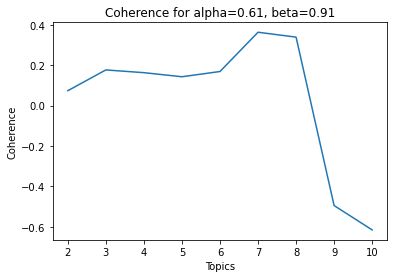

In [23]:
plt.plot(df_blog1['Topics'], df_blog1['Coherence'])
plt.title('Coherence for alpha=0.61, beta=0.91')
plt.ylabel('Coherence')
plt.xlabel('Topics')

In [17]:
dfcopy_blog = df_blog.copy()

In [14]:
df_topics_blog = dfcopy_blog[dfcopy_blog['Topics']==7]
df_topics_blog.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
163,100% Corpus,7,0.61,0.9099999999999999,0.363414
162,100% Corpus,7,0.61,0.61,0.361373
153,100% Corpus,7,0.01,0.9099999999999999,0.346211
177,100% Corpus,7,asymmetric,0.61,0.344937
166,100% Corpus,7,0.9099999999999999,0.31,0.336044
167,100% Corpus,7,0.9099999999999999,0.61,0.325774
161,100% Corpus,7,0.61,0.31,0.325193
156,100% Corpus,7,0.31,0.31,0.323726
175,100% Corpus,7,asymmetric,0.01,0.318015
173,100% Corpus,7,symmetric,0.9099999999999999,0.308840


In [ ]:
coherence_max_blog = df_topics_blog['Coherence'].max()
coherence_max_blog

In [ ]:
percent_improved_blog = ((coherence_max_blog-coherence_lda_blog)/coherence_lda_blog)*100
percent_improved_blog

### 인스타

In [ ]:
import tqdm

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Hyperparameter tuning range정의:

# Topics (k값) range
min_topics = 2
max_topics = 14
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus_insta)
corpus_sets = [corpus_insta]

corpus_title = ['100% Corpus']

model_results_insta = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar2 = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values_uci(corpus=corpus_sets[i], d=id2word_insta, 
                                                  k=k, a=a, b=b, tokens=text_token_insta)
                    # Save the model results
                    model_results_insta['Validation_Set'].append(corpus_title[i])
                    model_results_insta['Topics'].append(k)
                    model_results_insta['Alpha'].append(a)
                    model_results_insta['Beta'].append(b)
                    model_results_insta['Coherence'].append(cv)
                    
                    pbar2.update(1)
    pd.DataFrame(model_results_insta).to_csv('./LDAresults/lda_tuning_results_insta.csv', index=False)
    pbar2.close()

In [ ]:
df_insta = pd.DataFrame(model_results_insta)

In [ ]:
df_insta = pd.read_csv('./LDAresults/lda_tuning_results_insta.csv')

In [ ]:
df_insta.head()

In [ ]:
dfcopy_insta = df_insta.copy()

In [ ]:
draw_plot(dfcopy_insta,0.01,0.61)

In [ ]:
df_topics_insta = dfcopy_insta[dfcopy_insta['Topics']==4]
df_topics_insta.sort_values(by="Coherence", ascending=False)

In [ ]:
coherence_max_insta = df_topics_insta['Coherence'].max()
coherence_max_insta

In [ ]:
percent_improved_insta = ((coherence_max_insta-coherence_lda_insta)/coherence_lda_insta)*100
percent_improved_insta

### 카페

In [ ]:
import tqdm

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Hyperparameter tuning range정의:

# Topics (k값) range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus_cafe)
corpus_sets = [corpus_cafe]

corpus_title = ['100% Corpus']

model_results_cafe = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values_uci(corpus=corpus_sets[i], d=id2word_cafe, 
                                                  k=k, a=a, b=b, tokens=text_token_cafe)
                    # Save the model results
                    model_results_cafe ['Validation_Set'].append(corpus_title[i])
                    model_results_cafe ['Topics'].append(k)
                    model_results_cafe ['Alpha'].append(a)
                    model_results_cafe ['Beta'].append(b)
                    model_results_cafe ['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results_cafe ).to_csv('./LDAresults/lda_tuning_results_cafe.csv', index=False)
    pbar.close()

In [ ]:
df_cafe = pd.DataFrame(model_results_cafe)

In [ ]:
df_cafe = pd.read_csv('./LDAresults/lda_tuning_results_cafe.csv')

In [ ]:
df_cafe.head()

In [ ]:
dfcopy_cafe = df_cafe.copy()

In [ ]:
draw_plot(dfcopy_cafe,0.61,0.91)

In [ ]:
df_topics_cafe = dfcopy_cafe[dfcopy_cafe['Topics']==7]
df_topics_cafe.sort_values(by="Coherence", ascending=False)

In [ ]:
coherence_max_cafe = df_topics_cafe['Coherence'].max()
coherence_max_cafe

In [ ]:
percent_improved_cafe = ((coherence_max_cafe-coherence_lda_cafe)/coherence_lda_cafe)*100
percent_improved_cafe

## 8. final model visualization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### 통합

In [ ]:
k=4

lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,#num of docs to be used each training
                                           passes=100, #num of passes thru corpus during training
                                           alpha=0.31,
                                           eta='auto')

In [ ]:
topics = lda_model_final.print_topics(num_words=10)
for topic in topics:
    print(topic)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model_final, corpus, id2word)
pyLDAvis.display(vis)

In [ ]:
pyldavis_html_path='./LDAresults/LDAvis_all.html'
pyLDAvis.save_html(vis, pyldavis_html_path)

### 블로그

In [ ]:
k=7

lda_model_final_blog = gensim.models.LdaMulticore(corpus=corpus_blog,
                                           id2word=id2word_blog,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,#num of docs to be used each training
                                           passes=100, #num of passes thru corpus during training
                                           alpha=0.31,
                                           eta='auto')

In [ ]:
topics = lda_model_final_blog.print_topics(num_words=10)
for topic in topics:
    print(topic)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis_blog = gensimvis.prepare(lda_model_final_blog, corpus_blog, id2word_blog)
pyLDAvis.display(vis_blog)

In [ ]:
pyldavis_html_path='./LDAresults/LDAvis_blog.html'
pyLDAvis.save_html(vis_blog, pyldavis_html_path)

### 인스타

In [ ]:
k=7

lda_model_final_insta = gensim.models.LdaMulticore(corpus=corpus_insta,
                                           id2word=id2word_insta,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,#num of docs to be used each training
                                           passes=100, #num of passes thru corpus during training
                                           alpha=0.31,
                                           eta='auto')

In [ ]:
topics = lda_model_final_insta.print_topics(num_words=10)
for topic in topics:
    print(topic)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis_insta = gensimvis.prepare(lda_model_final_insta, corpus_insta, id2word_insta)
pyLDAvis.display(vis_insta)

In [ ]:
pyldavis_html_path='./LDAresults/LDAvis_insta.html'
pyLDAvis.save_html(vis_insta, pyldavis_html_path)

### 카페

In [ ]:
k=7
lda_model_final_cafe = gensim.models.LdaMulticore(corpus=corpus_cafe,
                                           id2word=id2word_cafe,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,#num of docs to be used each training
                                           passes=100, #num of passes thru corpus during training
                                           alpha=0.61,
                                           eta='auto')

In [ ]:
topics = lda_model_final_cafe.print_topics(num_words=10)
for topic in topics:
    print(topic)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis_cafe = gensimvis.prepare(lda_model_final_cafe, corpus_cafe, id2word_cafe)
pyLDAvis.display(vis_cafe)

In [ ]:
pyldavis_html_path='./LDAresults/LDAvis_cafe.html'
pyLDAvis.save_html(vis_cafe, pyldavis_html_path)